In [1]:
! pip show torch
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

Name: torch
Version: 2.8.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /home/scratch/samyak/micromamba/envs/qwen/lib/python3.10/site-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-cufile-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, bitsandbytes, cut-cross-entropy, peft, torchaudio, torchvision, unsloth, unsloth_zoo, xformers
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/scratch/samyak/micromamba/envs/qwen/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

==((====))==  Unsloth 2025.11.2: Fast Qwen3_Vl patching. Transformers: 4.57.1.
   \\   /|    NVIDIA L40S. Num GPUs = 1. Max memory: 44.392 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("unsloth/LaTeX_OCR", split = "train")

In [6]:
import os
import json
from PIL import Image
from datasets import Dataset as HFDataset

In [ ]:
def create_hf_dataset(images_dir, annotations_dir, max_samples=None):
    """Create HuggingFace Dataset from VRSBench data"""
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
    image_files.sort()
    
    # Limit to max_samples if specified
    if max_samples:
        image_files = image_files[:max_samples]
    
    data = {
        'image': [],
        'text': []  # Changed from 'caption' to 'text' to match your conversion function
    }
    
    for img_filename in image_files:
        # Load image
        img_path = os.path.join(images_dir, img_filename)
        image = Image.open(img_path).convert('RGB')
        
        # Load caption
        json_filename = img_filename.replace('.png', '.json')
        json_path = os.path.join(annotations_dir, json_filename)
        
        with open(json_path, 'r') as f:
            annotation = json.load(f)
        
        data['image'].append(image)
        data['text'].append(annotation['caption'])  # Store as 'text'
    
    return HFDataset.from_dict(data)

In [ ]:
from json.encoder import INFINITY


images_dir = "/home/samyak/scratch/interiit/samyak/GeoPixel/VRSBench/Images_train"
annotations_dir = "/home/samyak/scratch/interiit/samyak/GeoPixel/VRSBench/Annotations_train"

# Load dataset (first 100 images)
dataset = create_hf_dataset(images_dir, annotations_dir, max_samples=None)

In [ ]:
instruction = "Describe this satellite image in detail."  # Changed to be more relevant for satellite images

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content": [
              {"type": "text",  "text": instruction},
              {"type": "image", "image": sample["image"]}
          ]
        },
        { "role": "assistant",
          "content": [
              {"type": "text",  "text": sample["text"]}
          ]
        },
    ]
    return {"messages": conversation}

In [10]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [14]:
for sample in dataset:
    print(sample['image'])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE950>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE860>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE320>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE8C0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAFD00>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAFC10>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAF520>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE3E0>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAEC80>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAE950>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAFD30>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x767DCECAFD00>
<PIL.PngImagePlugin.PngImageFile image m

In [16]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[2]["image"]
instruction = "Describe the image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This is an aerial satellite image showing an industrial complex, dominated by a very large, circular cooling tower.

Here’s a detailed description:

- **Main Feature**: The most prominent object is a massive, circular cooling tower. It has a wide, open central aperture and a light-colored, possibly concrete or stone, exterior. Its circular shape is very distinct against the surrounding landscape. The top rim appears to have a decorative or structural pattern.

- **Surrounding Area**: The cooling tower is situated within a complex of buildings and infrastructure:
  - To the left and upper portions of the image, there are clusters of smaller, low-rise industrial


In [17]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [18]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100 | Num Epochs = 3 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,0.809300
2,0.856800
3,0.838300
4,0.741200
5,0.715200
6,0.651300
7,0.606600
8,0.532500
9,0.503300
10,0.490400


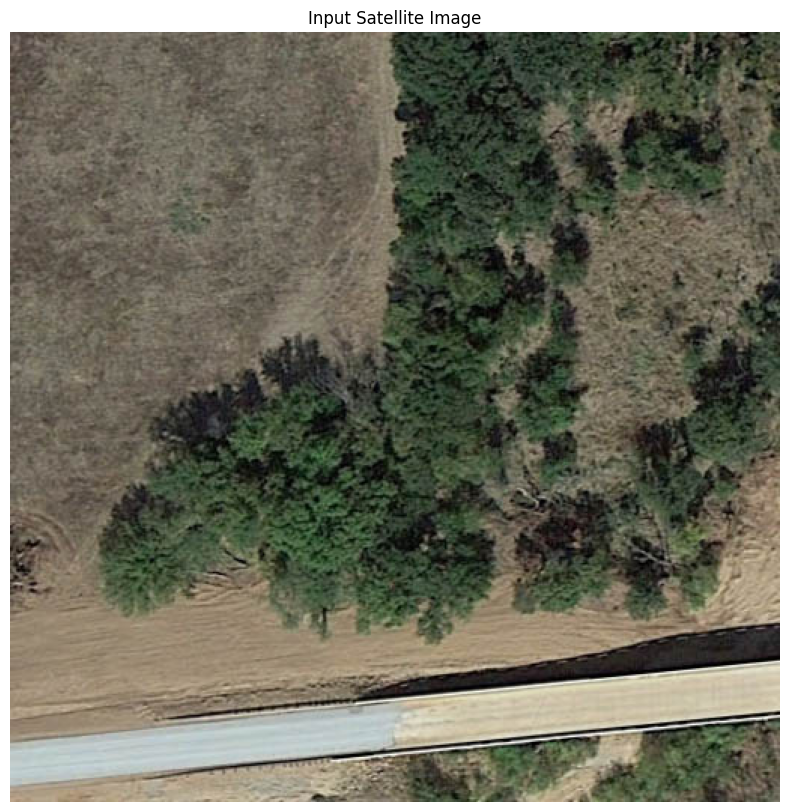

Model output:
This satellite image from GoogleEarth, sourced from GoogleEarth and NASA, shows a small cluster of green vegetation surrounded by a barren field, with a straight, horizontal line extending across the bottom.<|im_end|>

Ground truth caption:
The image provided is from Google Earth, showcasing a natural landscape intercepted by a man-made structure. The image is in color. There is a bridge visible in the bottom section of the image, spanning from the left to right across the frame. The bridge bisects a stretch of land that is a combination of vegetation and bare earth. The foliage has a mix of green hues suggesting a variety of tree species or different stages of foliage health.


In [25]:
from transformers import TextStreamer
import matplotlib.pyplot as plt

# Enable model for inference
FastVisionModel.for_inference(model)

# Get image from your converted dataset
image = dataset[150]["image"]  # This will be a PIL Image

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.title("Input Satellite Image")
plt.show()

# Set instruction
instruction = "Describe this image."

# Create messages in the format expected by the model
messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]

# Apply chat template
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

# Tokenize inputs with image
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# Set up text streamer for real-time output
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

# Generate response
print("Model output:")
_ = model.generate(
    **inputs, 
    streamer=text_streamer, 
    max_new_tokens=128,
    use_cache=True, 
    temperature=1.5, 
    min_p=0.1
)

# Optional: Compare with ground truth
print("\n" + "="*50)
print("Ground truth caption:")
print(dataset[150]["text"])